# Barrido 2D: k_intra × k_inter

**Objetivo:** Encontrar valores óptimos de acoplamiento intra e inter-poblacional

**Criterios de optimalidad:**
- Firing rate estable: 5-15 Hz
- Oscilaciones claras: pico espectral definido en beta (13-30 Hz)
- CV_ISI moderado: 0.5-1.5 (régimen irregular)
- Correlación baseline: 0.1-0.4 (margen para modulación con delays)

**Configuración:**
- Dos ROIs idénticas (A, B) sin conexión inter-poblacional
- Balance E/I fijo: k_inh = 3.9 × k_intra
- Barrido: k_intra [0.5, 2.5], k_inter_ratio [0.1, 1.0]
- 1 trial por condición (4 sims totales - test rápido)

In [1]:
# Setup
import os
import sys
from pathlib import Path

if Path.cwd().name != 'neurodelays':
    os.chdir('../..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from brian2 import *
from datetime import datetime
import json
from tqdm.auto import tqdm

from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import (
    spikes_to_population_rate,
    power_spectrum_analysis,
    cross_correlation_analysis,
    analyze_simulation_results,
    palmigiano_analysis, print_network_statistics_table
)
from src.two_populations.plots.basic_plots import plot_raster_results, plot_voltage_traces
from src.two_populations.plots.dashboard_plots import (
    plot_population_dashboard, 
    plot_connectivity_dashboard, 
    plot_spectrogram, 
    plot_palmigiano_dashboard
)

from src.two_populations.helpers.validator import (
    add_validation_to_analysis, 
    plot_population_validation_dashboard, 
    print_validation_summary
)
from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="k_sweep_2d",
    console_level="INFO",
    file_level="DEBUG",
    log_to_file=False
)

logger.info(f"Working directory: {Path.cwd()}")

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO       Cache size for target 'cython': 2781 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/ubuntu-deduce/.cython/brian_extensions' directory. [brian2]
INFO     | __main__:<module>:47 - Working directory: /home/ubuntu-deduce/Projects/izhikevich


In [2]:
# =============================================================================
# CONFIGURACIÓN DEL BARRIDO
# =============================================================================

# Parámetros fijos de población
POPULATION_PARAMS = {
    'Ne': 800,
    'Ni': 200,
    'noise_exc': 0.88,       # Peso de PoissonInput para excitatorias (calibrado)
    'noise_inh': 0.6,        # noise_exc * 0.68
    'p_intra': 0.1,
    'delay': 0.0,            # Delay intra-poblacional
    'rate_hz': 10.0,         # Tasa base de PoissonInput
    'stim_start_ms': None,   # Estimulación constante desde t=0
    'stim_duration_ms': None,
    'stim_base': 1.0,
    'stim_elevated': None
}

# Valores del barrido (test rápido)
K_INTRA_VALUES = np.linspace(0.1, 3.0, 10)  # de 0.3 a 3.0 en 10 pasos
K_INTER_RATIOS = np.linspace(0.1, 3.0, 10)

# Configuración de simulación
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': 2500,
    'warmup_ms': 500,
    'n_trials': 3,
    'fixed_seed': 100,
    'variable_seed_base': 200
}

logger.info(f"Barrido: {len(K_INTRA_VALUES)} k_intra × {len(K_INTER_RATIOS)} k_inter × {SIM_CONFIG['n_trials']} trials")
logger.info(f"Total simulaciones: {len(K_INTRA_VALUES) * len(K_INTER_RATIOS) * SIM_CONFIG['n_trials']}")

INFO     | __main__:<module>:34 - Barrido: 10 k_intra × 10 k_inter × 3 trials
INFO     | __main__:<module>:35 - Total simulaciones: 300


In [3]:
# =============================================================================
# MÉTRICAS ADICIONALES
# =============================================================================

def compute_ei_ratio(spike_mon, N_exc, N_total, warmup_ms, T_total):
    """Ratio explícito de firing rates E/I"""
    times = np.array(spike_mon.t/ms)
    indices = np.array(spike_mon.i)
    
    mask = (times >= warmup_ms) & (times < T_total)
    times_filt = times[mask]
    indices_filt = indices[mask]
    
    T_analysis = (T_total - warmup_ms) / 1000
    
    exc_rate = np.sum(indices_filt < N_exc) / (N_exc * T_analysis)
    inh_rate = np.sum(indices_filt >= N_exc) / ((N_total - N_exc) * T_analysis)
    
    return exc_rate / max(inh_rate, 0.01)

def compute_burst_ratio(spike_times, warmup_ms, T_total, bin_ms=50):
    """Burstiness: std/mean de activity bins"""
    spike_times_filt = spike_times[(spike_times >= warmup_ms) & (spike_times < T_total)]
    
    if len(spike_times_filt) < 10:
        return np.nan
    
    bins = np.arange(warmup_ms, T_total, bin_ms)
    counts, _ = np.histogram(spike_times_filt, bins)
    
    return counts.std() / max(counts.mean(), 0.01)

def compute_cv_isi(spike_monitor, warmup_ms=500):
    """Calcular CV del ISI (coeficiente de variación de intervalos entre spikes)"""
    spike_times = np.array(spike_monitor.t/ms)
    spike_indices = np.array(spike_monitor.i)
    
    # Filtrar warmup
    valid_mask = spike_times >= warmup_ms
    spike_times = spike_times[valid_mask]
    spike_indices = spike_indices[valid_mask]
    
    if len(spike_times) < 10:
        return np.nan
    
    # Calcular ISIs por neurona y promediar CVs
    cvs = []
    for neuron_id in np.unique(spike_indices):
        neuron_spikes = spike_times[spike_indices == neuron_id]
        if len(neuron_spikes) >= 3:
            isis = np.diff(neuron_spikes)
            if np.mean(isis) > 0:
                cvs.append(np.std(isis) / np.mean(isis))
    
    return np.mean(cvs) if cvs else np.nan

# =============================================================================
# FUNCIÓN DE SIMULACIÓN INDIVIDUAL
# =============================================================================

def run_single_simulation(k_intra, k_inter_ratio, trial_idx, i):
    """
    Ejecuta simulación con k_intra y k_inter dados.
    Sin conexión inter-poblacional (solo para caracterizar poblaciones aisladas).
    """
    start_scope()
    
    k_inter = k_intra * k_inter_ratio
    
    fixed_seed = SIM_CONFIG['fixed_seed']
    variable_seed = SIM_CONFIG['variable_seed_base']
    
    network = IzhikevichNetwork(
        dt_val=SIM_CONFIG['dt_ms'],
        T_total=SIM_CONFIG['T_ms'],
        fixed_seed=fixed_seed,
        variable_seed=variable_seed,
        trial=trial_idx
    )
    
    # Crear poblaciones idénticas pero SIN conexión inter
    # Balance E/I: k_inh = 3.9 × k_intra
    pop_A = network.create_population2(
        'A',
        k_exc=k_intra,
        k_inh=k_intra * 3.9,
        **POPULATION_PARAMS
    )
    
    pop_B = network.create_population2(
        'B',
        k_exc=k_intra,
        k_inh=k_intra * 3.9,
        **POPULATION_PARAMS
    )
    
    syn_AB = network.connect_populations(
        'A',
        'B',
        p_inter= 0.02,
        weight_scale = k_inter,
        delay_value = 0.0,
    )
    syn_BA = network.connect_populations(
        'B',
        'A',
        p_inter= 0.02,
        weight_scale = k_inter,
        delay_value = 0.0,
    )
    
    # Monitores
    network.setup_monitors(['A', 'B'], record_v_dt=0.5, sample_fraction=0.3)
    results = network.run_simulation()
    
    
    try:
        # Análisis completo con analyze_simulation_results
        conn = analyze_simulation_results(
            results['A']['spike_monitor'],
            results['B']['spike_monitor'],
            1000,
            f"k_intra_{k_intra}_ratio_{k_inter_ratio}_trial_{trial_idx}",
            warmup=SIM_CONFIG['warmup_ms'],
            state_monitors={'A': network.monitors['A'], 'B': network.monitors['B']},
            delays={'AB': np.array(results['delays_AB']), 'BA': np.array(results['delays_BA'])},
            signal_mode='lfp'
        )
        
        # === EXTRAER MÉTRICAS YA CALCULADAS ===
        # Firing rates (ya están en time_series)
        fr_A = conn['time_series']['fr_A']
        fr_B = conn['time_series']['fr_B']
        mean_rate_A = np.mean(fr_A)
        mean_rate_B = np.mean(fr_B)
        
        # Power espectral beta (ya está en power_A/B)
        beta_power_A = conn['power_A']['beta_power']
        beta_power_B = conn['power_B']['beta_power']
        
        # Cross-correlation (ya está calculada)
        cc_peak = conn['cross_corr_peak']
        cc_lag = conn['cross_corr_lag']
        
        # === CALCULAR SOLO LO QUE FALTA ===
        # CV_ISI no está en analyze_simulation_results
        cv_A = compute_cv_isi(results['A']['spike_monitor'], SIM_CONFIG['warmup_ms'])
        cv_B = compute_cv_isi(results['B']['spike_monitor'], SIM_CONFIG['warmup_ms'])
        
        ei_ratio_A = compute_ei_ratio(results['A']['spike_monitor'], 
                                            POPULATION_PARAMS['Ne'], 
                                            POPULATION_PARAMS['Ne'] + POPULATION_PARAMS['Ni'],
                                            SIM_CONFIG['warmup_ms'], SIM_CONFIG['T_ms'])
        
        burst_A = compute_burst_ratio(np.array(results['A']['spike_monitor'].t/ms),
                                    SIM_CONFIG['warmup_ms'], SIM_CONFIG['T_ms'])
        

        # === VISUALIZACIONES (solo para trial_idx == 0) ===
        if trial_idx == 0:
            
            # Envolver en diccionario
            results_dict = {f"k_intra_{k_intra}_ratio_{k_inter_ratio}_trial_{trial_idx}": conn}
            plot_dir = Path(f"./results/experiments/k_sweep_2d/plots_{i}/k{k_intra}_r{k_inter_ratio}")
            plot_dir.mkdir(parents=True, exist_ok=True)
            
            print_network_statistics_table(
                results, network, 
                N_exc=800, N_inh=200, 
                T_total=SIM_CONFIG['T_ms'], 
                warmup=SIM_CONFIG['warmup_ms']
            )
            
            print(f"\n{'='*70}")
            print(f"PLOTS: k_intra={k_intra}, k_inter_ratio={k_inter_ratio}")
            print(f"{'='*70}")
            
            # 1. Raster
            try:
                fig_raster = plot_raster_results(
                    results,
                    N_exc=POPULATION_PARAMS['Ne'],
                    N_total=POPULATION_PARAMS['Ne'] + POPULATION_PARAMS['Ni'],
                    warmup_ms=SIM_CONFIG['warmup_ms'],
                    neuron_limit=None
                )
                if fig_raster is not None:
                    fig_raster.savefig(plot_dir / 'raster.png', dpi=150, bbox_inches='tight')
                    # plt.show()
                    plt.close(fig_raster)
            except Exception as e:
                print(f"Error en raster: {e}")
            
            # 2. Population dashboard
            try:
                fig_pop = plot_population_dashboard(results_dict)
                if fig_pop is not None:
                    fig_pop.savefig(plot_dir / 'population.png', dpi=150, bbox_inches='tight')
                    # plt.show()
                    plt.close(fig_pop)
            except Exception as e:
                print(f"Error en population: {e}")
            
            # 3. Connectivity dashboard
            try:
                fig_conn = plot_connectivity_dashboard(results_dict)
                if fig_conn is not None:
                    fig_conn.savefig(plot_dir / 'connectivity.png', dpi=150, bbox_inches='tight')
                    # plt.show()
                    plt.close(fig_conn)
            except Exception as e:
                print(f"Error en connectivity: {e}")
            
            # 4. Spectrogram
            try:
                fig_spec = plot_spectrogram(results_dict)
                if fig_spec is not None:
                    fig_spec.savefig(plot_dir / 'spectrogram.png', dpi=150, bbox_inches='tight')
                    # plt.show()
                    plt.close(fig_spec)
            except Exception as e:
                print(f"Error en spectrogram: {e}")
                
            # 5. validation
            try:
                # Add validation metrics
                validation_results = add_validation_to_analysis(results_dict)
                print_validation_summary(validation_results)
                
                # Dashboards
                fig_val = plot_population_validation_dashboard(validation_results)
                
                if fig_val is not None:
                    fig_val.savefig(plot_dir / 'validation.png', dpi=150, bbox_inches='tight')
                    # plt.show()
                    plt.close(fig_val)
            except Exception as e:
                print(f"Error en fig_val: {e}")
                    
            # 6. Palmigiano
            try:
                metrics_palmi, lfp_A, lfp_B, fs_palmi = palmigiano_analysis(results, start_ms=SIM_CONFIG['warmup_ms'])
                fig_palmi = plot_palmigiano_dashboard(metrics_palmi, lfp_A, lfp_B, fs=1000/results['dt'])
                if fig_palmi is not None:
                    fig_palmi.savefig(plot_dir / 'palmigiano.png', dpi=150, bbox_inches='tight')
                    # plt.show()
                    plt.close(fig_palmi)
            except Exception as e:
                print(f"Error en palmigiano: {e}")
            
            plt.close('all')
            
        return {
            'k_intra': k_intra,
            'k_inter': k_inter,
            'k_inter_ratio': k_inter_ratio,
            'trial': trial_idx,
            # Básicas
            'mean_rate_A': mean_rate_A,
            'mean_rate_B': mean_rate_B,
            'cv_A': cv_A,
            'cv_B': cv_B,
            # Espectrales
            'beta_power_A': conn['power_A']['beta_power'],
            'alpha_power_A': conn['power_A']['alpha_power'],
            'gamma_power_A': conn['power_A']['gamma_power'],
            # Acoplamiento
            'cc_peak': conn['cross_corr_peak'],
            'cc_lag': conn['cross_corr_lag'],
            'plv_alpha': conn['plv_alpha'],
            'coherence_peak': conn['coherence_peak'],
            'coherence_freq': conn['coherence']['peak_freq'],
            # Timescales
            'tau_A': conn['tau_A'],
            'tau_B': conn['tau_B'],
            # Balance y patrón
            'ei_ratio_A': ei_ratio_A,
            'burst_ratio_A': burst_A
        }
            
    except Exception as e:
        logger.error(f"Error en k={k_intra}, ratio={k_inter_ratio}, trial={trial_idx}: {e}")
        return {
            'k_intra': k_intra,
            'k_inter': k_inter,
            'k_inter_ratio': k_inter_ratio,
            'trial': trial_idx,
            'mean_rate_A': np.nan, 'mean_rate_B': np.nan,
            'cv_A': np.nan, 'cv_B': np.nan,
            'beta_power_A': np.nan, 'alpha_power_A': np.nan, 'gamma_power_A': np.nan,
            'cc_peak': np.nan, 'cc_lag': np.nan,
            'plv_alpha': np.nan, 'coherence_peak': np.nan, 'coherence_freq': np.nan,
            'tau_A': np.nan, 'tau_B': np.nan,
            'ei_ratio_A': np.nan, 'burst_ratio_A': np.nan
        }


In [4]:
# =============================================================================
# EJECUTAR BARRIDO (OPCIÓN 2: Multiprocessing)
# =============================================================================
import multiprocessing
from multiprocessing import Pool
from tqdm.auto import tqdm

i = datetime.now().strftime("%Y%m%d_%H%M")

N_JOBS = multiprocessing.cpu_count() - 2

tasks = [
    (k_intra, k_inter_ratio, trial)
    for k_intra in K_INTRA_VALUES
    for k_inter_ratio in K_INTER_RATIOS
    for trial in range(SIM_CONFIG['n_trials'])
]

def run_task_wrapper(params):
    k_intra, k_inter_ratio, trial = params
    try:
        return run_single_simulation(k_intra, k_inter_ratio, trial, i)
    except Exception as e:
        return {
            'k_intra': k_intra,
            'k_inter': k_intra * k_inter_ratio,
            'k_inter_ratio': k_inter_ratio,
            'trial': trial,
            'mean_rate_A': np.nan,
            'mean_rate_B': np.nan,
            'cv_A': np.nan,
            'cv_B': np.nan,
            'beta_power_A': np.nan,
            'beta_power_B': np.nan,
            'cc_peak': np.nan,
            'cc_lag': np.nan
        }

with Pool(N_JOBS) as pool:
    all_results = list(tqdm(pool.imap(run_task_wrapper, tasks), total=len(tasks), desc="Barrido 2D"))

logger.info(f"Barrido completado: {len(all_results)} simulaciones")

SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
SUCCESS  | src.two_pop

Barrido 2D:   0%|          | 0/300 [00:00<?, ?it/s]

INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:


PLOTS: k_intra=0.1, k_inter_ratio=0.1


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_0.42222222222222217_trial_0 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.173 @ -453.5ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.585, PLI: 0.585
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.624 @ 10.5Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=4.5ms, B=4.4ms
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.379, CV_population=0.536
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.346, CV_population=0.539
INFO     | src.two_populations.metrics:print_network_statistics_table:705 - 
INFO     | src.two_populations.metrics:print_network_statistics_table:707 - COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 500ms)
INFO     | 


PLOTS: k_intra=0.1, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_0.1_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.166 @ 40.5ms
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_0.1_trial_2 (lfp) ===
INFO 


PLOTS: k_intra=0.1, k_inter_ratio=0.7444444444444444


INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.345, CV_population=0.539


INFO     | src.two_populations.metrics:print_network_statistics_table:705 - 
INFO     | src.two_populations.metrics:print_network_statistics_table:707 - COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 500ms)


INFO     | src.two_populations.metrics:print_network_statistics_table:708 - ================================================================================
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_0.42222222222222217_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:print_network_statistics_table:710 - Métrica                   Población A               Población B              
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.173 @ -453.5ms
INFO     | src.two_populations.metrics:print_network_statistics_table:711 - ---------------------------------------------------------------------------
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.585, PLI: 0.585
INFO     | src.two_populations.metrics:print_network_statistics_table:720 - ARQUITECTURA         


PLOTS: k_intra=0.1, k_inter_ratio=1.0666666666666667

INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses


INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses


INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn


INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(0.10666666666666667),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
INFO     | src.two_populations.model:connect_populations:479 - Connecting B->A using seeds: fixed=100, variabl

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201


Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(0.1711111111111111),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de del

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199


Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating P


PLOTS: k_intra=0.1, k_inter_ratio=1.3888888888888888


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_1.0666666666666667_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.120 @ -169.7ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.256, PLI: 0.075
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.583 @ 0.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=5.0ms, B=3.7ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:


PLOTS: k_intra=0.1, k_inter_ratio=1.711111111111111


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.1, k_inter_ratio=2.033333333333333


INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO     | src.two_populations.helpers.validator:print_validation_summary:488 - NEURAL ACTIVITY VALIDATION SUMMARY
INFO     | src.two_populations.helpers.validator:print_validation_summary:489 - ============================================================
INFO     | src.two_populations.helpers.validator:print_validation_summary:492 - 
k_intra_0.1_ratio_1.711111111111111_trial_0_A:
INFO     | src.two_populations.helpers.validator:print_validation_summary:493 - ----------------------------------------
INFO     | src.two_populations.helpers.validator:print_validation_summary:499 - Population rates: Exc=4.43 Hz, Inh=7.32 Hz
INFO     | src.two_populations.helpers.validator:print_validation_summary:500 - Active neurons: Exc=100.0%, Inh=88.0%
INFO     | src.two_populations.helpers.validator:print_validation_su

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(0.04222222222222222),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'


PLOTS: k_intra=0.1, k_inter_ratio=2.3555555555555556


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_2.3555555555555556_trial_2 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.171 @ -453.1ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.704, PLI: 0.704
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.719 @ 66.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=4.7ms, B=4.3ms
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_2.3555555555555556_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.171 @ -453.1ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.704, PLI: 0.704
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.719 @ 66.0Hz
INFO     | src.two_populations.metr

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_2.6777777777777776_trial_0 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr:


PLOTS: k_intra=0.1, k_inter_ratio=2.6777777777777776


INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.378, CV_population=0.534
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.347, CV_population=0.540
INFO     | src.two_populations.metrics:print_network_statistics_table:705 - 
INFO     | src.two_populations.metrics:print_network_statistics_table:707 - COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 500ms)
INFO     | src.two_populations.metrics:print_network_statistics_table:708 - ================================================================================
INFO     | src.two_populations.metrics:print_network_statistics_table:710 - Métrica                   Población A               Población B              
INFO     | src.two_populations.metrics:print_network_statistics_table:711 - ---------------------------------------------------------------------------
INFO     | src.two_populations.metrics:print_network_statistics_table:720 - ARQUIT

INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.158 @ -454.6ms



PLOTS: k_intra=0.1, k_inter_ratio=3.0

INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.652, PLI: 0.652


INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.690 @ 0.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=4.4ms, B=4.3ms


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.1_ratio_2.6777777777777776_trial_2 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.158 @ -454.6ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.652, PLI: 0.652
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.690 @ 0.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=4.4ms, B=4.3ms
WARNING    /home/ubuntu-deduce/Projec

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.

INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=0.1


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.42222222222222217_ratio_0.1_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.134 @ 5.0ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.412, PLI: 0.259
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.577 @ 24.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=6.0ms, B=3.8ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
WARNING    /home/ubuntu-deduce/Project

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=0.7444444444444444


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.42222222222222217_ratio_0.42222222222222217_trial_0 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.151 @ -326.9ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.437, PLI: 0.155
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.550 @ 33.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=8.7ms, B=4.3ms
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.372, CV_population=0.547
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.360, CV_population=0.544
INFO     | src.two_populations.metrics:print_network_statistics_table:705 - 
INFO     | src.two_populations.metrics:print_network_statistics_table:707 - COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 50


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.42222222222222217_ratio_0.42222222222222217_trial_2 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.151 @ -326.9ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.437

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.42222222222222217_ratio_0.7444444444444444_trial_2 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.152 @ 4.9ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.398, PLI: 0.274
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.428 @ 33.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=5.5ms, B=4.1ms
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_popu

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:_create_stimul


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=1.0666666666666667


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=1.3888888888888888


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.42222222222222217_ratio_1.3888888888888888_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.203 @ -456.3ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.407,


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=1.711111111111111


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO     | src.two_populations.helpers.validator:print_validation_summary:488 - NEURAL ACTIVITY VALIDATION SUMMARY
INFO     | src.two_populations.helpers.validator:print_validation_summary:489 - ============================================================
I

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating 


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=2.033333333333333


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=2.3555555555555556


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.4

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=2.6777777777777776


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.42222222222222217_ratio_2.6777777777777776_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.327 @ 1.6ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.424, PL


PLOTS: k_intra=0.42222222222222217, k_inter_ratio=3.0
Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | s


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=0.1


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonI


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.7

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(1.0339506172839505),  p_in


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=0.7444444444444444


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.7444444444444444_ratio_0.7444444444444444_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.172 @ 1.9ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.544, PLI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=1.0666666666666667


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.7


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=1.3888888888888888


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.

INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses


INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(1.7535802469135802),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed stat


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=1.711111111111111


INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(1.9934567901234563),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=2.033333333333333


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.7

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=2.3555555555555556


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_0.7


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=2.6777777777777776


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=0.7444444444444444, k_inter_ratio=3.0


INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(0.4503703703703703),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
INFO     | src.two_populations.model:connect_populations:479 - Connecting B->A using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - 

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.w

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=0.1


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.0


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=0.7444444444444444


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=1.0666666666666667


INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(2.1688888888888886),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
INFO     | src.two_populations.model:connect_populations:479 - Connecting B->A using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=1.3888888888888888


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=1.711111111111111


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.0


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=2.033333333333333


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=2.3555555555555556


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=2.6777777777777776


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.0666666666666667, k_inter_ratio=3.0


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.0


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=0.1


INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(1.0339506172839505),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populatio

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.3

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=0.7444444444444444


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.3

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=1.0666666666666667


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.3


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=1.3888888888888888

INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(2.824074074074074),  p_inter=0.02, n_conn=19942


INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'


INFO     | src.two_populations.model:connect_populations:479 - Connecting B->A using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(2.824074074074074),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when 

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=1.711111111111111


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.3888888888888888_ratio_1.3888888888888888_trial_2 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.581 @ -3.0ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.740, PLI: 0.130
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.806 @ 9.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=13.7ms, B=3.8ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_popu

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=2.033333333333333


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.3

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=2.3555555555555556


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.3


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=2.6777777777777776


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.

INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'


INFO     | src.two_populations.model:connect_populations:479 - Connecting B->A using seeds: fixed=100, variable(current)=200
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(0.722469135802469),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 


PLOTS: k_intra=1.3888888888888888, k_inter_ratio=3.0


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.3

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.711111111111111, k_inter_ratio=0.1


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.7

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.711111111111111, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.7


PLOTS: k_intra=1.711111111111111, k_inter_ratio=0.7444444444444444


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.711111111111111, k_inter_ratio=1.0666666666666667


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.7

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.711111111111111, k_inter_ratio=1.3888888888888888


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.7

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.711111111111111, k_inter_ratio=1.711111111111111


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.7


PLOTS: k_intra=1.711111111111111, k_inter_ratio=2.033333333333333


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.711111111111111_ratio_2.3555555555555556_trial_0 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.967 @ 0.5ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.969, PLI: 0.089
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.974 @ 15.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=8.7ms, B=8.5ms
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_popula


PLOTS: k_intra=1.711111111111111, k_inter_ratio=2.3555555555555556


INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(0.20333333333333334),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
INFO     | src.two_populations.model:connect_populations:479 - Connecting B->A using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float6


PLOTS: k_intra=1.711111111111111, k_inter_ratio=2.6777777777777776
======================================================================Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.



SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=1.711111111111111, k_inter_ratio=3.0


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_1.7


PLOTS: k_intra=2.033333333333333, k_inter_ratio=0.1


INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(1.5137037037037033),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
INFO     | src.two_populations.model:connect_populations:479 - Connecting B->A using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.033333333333333, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.033333333333333_ratio_0.42222222222222217_trial_2 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:56


PLOTS: k_intra=2.033333333333333, k_inter_ratio=0.7444444444444444


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc 


PLOTS: k_intra=2.033333333333333, k_inter_ratio=1.0666666666666667


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.0


PLOTS: k_intra=2.033333333333333, k_inter_ratio=1.3888888888888888


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.033333333333333, k_inter_ratio=1.711111111111111


INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(4.78962962962963),  p_inter=0.02, n_conn=19942
INFO     | src.two_populations.model:connect_populations:513 - Distribución de delays inter: delay_dist='constant'
INFO     | src.two_populations.model:connect_populations:479 - Connecting B->A using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float64(4

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.w

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.388, CV_population=2.266
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.389, CV_population=2.331
INFO     | src.two_populations.metrics:print_network_statistics_table:705 - 
INFO     | src.two_populations.metrics:print_network_statistics_table:707 - COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 500ms)
INFO     


PLOTS: k_intra=2.033333333333333, k_inter_ratio=2.033333333333333


INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connec

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.033333333333333, k_inter_ratio=2.3555555555555556


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.0


PLOTS: k_intra=2.033333333333333, k_inter_ratio=2.6777777777777776


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.033333333333333, k_inter_ratio=3.0


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.033333333333333_ratio_2.6777777777777776_trial_2 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.983 @ 0.2ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.757, PLI: 0.029
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.987 @ 6.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=8.2ms, B=8.5ms
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision l

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=0.1


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO     | src.two_populations.helpers.validator:print_validation_summary:488 - NEURAL ACTIVITY VALIDATION SUMMARY
INFO     | src.two_populations.helpers.validator:print_validation_summary:489 - ============================================================
W

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.3


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=0.7444444444444444


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=1.0666666666666667
Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=1.3888888888888888


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=1.711111111111111


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.3


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=2.033333333333333


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=2.3555555555555556


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=2.6777777777777776


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.3555555555555556, k_inter_ratio=3.0


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.3555555555555556_ratio_3.0_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.985 @ -0.0ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.974, PLI: 0.013
INFO  


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=0.1


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.6

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.6


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=0.7444444444444444


INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO     | src.two_populations.helpers.validator:print_validation_summary:488 - NEURAL ACTIVITY VALIDATION SUMMARY
INFO     | src.two_populations.helpers.validator:print_validation_summary:489 - ============================================================
INFO     | src.two_populations.helpers.validator:print_validation_summary:492 - 
k_intra_2.6777777777777776_ratio_0.42222222222222217_trial_0_A:
INFO     | src.two_populations.helpers.validator:print_validation_summary:493 - ----------------------------------------
INFO     | src.two_populations.helpers.validator:print_validation_summary:499 - Population rates: Exc=6.18 Hz, Inh=11.41 Hz
INFO     | src.two_populations.helpers.validator:print_validation_summary:500 - Active neurons: Exc=100.0%, Inh=100.0%
INFO     | src.two_populations.helpers.validator:print_validation_summary:501 - Bursts: 0 total, 0.00 bursts/s
INFO     | src.two_populations.helpers.vali

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=1.0666666666666667


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.6


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=1.3888888888888888


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.6

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=1.711111111111111


INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO     | src.two_populations.helpers.validator:print_validation_summary:488 - NEURAL ACTIVITY VALIDATION SUMMARY
INFO     | src.two_populations.helpers.validator:print_validation_summary:489 - ============================================================
INFO     | src.two_populations.helpers.validator:print_validation_summary:492 - 
k_intra_2.6777777777777776_ratio_1.3888888888888888_trial_0_A:
INFO     | src.two_populations.helpers.validator:print_validation_summary:493 - ----------------------------------------
INFO     | src.two_populations.helpers.validator:print_validation_summary:499 - Population rates: Exc=8.54 Hz, Inh=13.90 Hz
INFO     | src.two_populations.helpers.validator:print_validation_summary:500 - Active neurons: Exc=100.0%, Inh=100.0%
INFO     | src.two_populations.helpers.validator:print_validation_summary:501 - Bursts: 0 total, 0.00 bursts/s
INFO     | src.two_populations.helpers.valid

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=2.033333333333333


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=2.3555555555555556


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.6777777777777776_ratio_2.3555555555555556_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.987 @ 0.1ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.928, PLI


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=2.6777777777777776


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_2.6

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=2.6777777777777776, k_inter_ratio=3.0


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=3.0, k_inter_ratio=0.1


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 206, 'variable_A_current': 206, 'variable_B_current': 209}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=3.0, k_inter_ratio=0.42222222222222217


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI


PLOTS: k_intra=3.0, k_inter_ratio=0.7444444444444444


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0


PLOTS: k_intra=3.0, k_inter_ratio=1.0666666666666667


INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO     | src.two_populations.helpers.validator:print_validation_summary:488 - NEURAL ACTIVITY VALIDATION SUMMARY
INFO     | src.two_populations.helpers.validator:print_validation_summary:489 - ============================================================
INFO     | src.two_populations.helpers.validator:print_validation_summary:492 - 
k_intra_3.0_ratio_0.7444444444444444_trial_0_A:
INFO     | src.two_populations.helpers.validator:print_validation_summary:493 - ----------------------------------------
INFO     | src.two_populations.helpers.validator:print_validation_summary:499 - Population rates: Exc=7.16 Hz, Inh=12.70 Hz
INFO     | src.two_populations.helpers.validator:print_validation_summary:500 - Active neurons: Exc=100.0%, Inh=100.0%
INFO     | src.two_populations.helpers.validator:print_validation_summary:501 - Bursts: 0 total, 0.00 bursts/s
INFO     | src.two_populations.helpers.validator:print_vali

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0_ratio_1.0666666666666667_trial_1 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.923 @ 0.4ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.979, PLI: 0.228
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.950 @ 16.5Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=0.0ms, B=0.0ms
INFO     | src.two_populations.model:_c


PLOTS: k_intra=3.0, k_inter_ratio=1.3888888888888888


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonI

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


INFO     | src.two_populations.metrics:print_network_statistics_table:723 -   Sparsity                0.900                     0.899
INFO     | src.two_populations.metrics:print_network_statistics_table:725 - 
ACTIVIDAD                
INFO     | src.two_populations.metrics:print_network_statistics_table:726 -   Freq exc (Hz)           15.36                     15.44
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.metrics:print_network_statistics_table:727 -   Freq inh (Hz)           22.50                     23.33
INFO     | src.two_populations.metrics:print_network_statistics_table:728 -   Ratio E/I               0.68                      0.66
INFO     | src.two_populations.metri


PLOTS: k_intra=3.0, k_inter_ratio=1.711111111111111


INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for B with seed state: 201
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:266 - Population B (PoissonInput): 800E/200I, 80348+20166 syn
INFO     | src.two_populations.model:connect_populations:479 - Connecting A->B using seeds: fixed=100, variable(current)=200
INFO     | src.two_populations.model:connect_populations:500 - Distribución de pesos y conectividad inter: weight_dist='constant' , k_base=0.5 , weight_scale=np.float6

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:289 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:351 - PoissonGroup A: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO   


PLOTS: k_intra=3.0, k_inter_ratio=2.033333333333333


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0


PLOTS: k_intra=3.0, k_inter_ratio=2.3555555555555556


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0_ratio_2.6777777777777776_trial_0 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.987 @ 0.1ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.808, PLI: 0.019
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.998 @ 0.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=3.7ms, B=3.5ms
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.253, CV_population=2.641
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.245, CV_population=2.653
INFO     | src.two_populations.metrics:print_network_statistics_table:705 - 
INFO     | src.two_populations.metrics:print_network_statistics_table:707 - COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 500ms)
INFO     | src.t


PLOTS: k_intra=3.0, k_inter_ratio=2.6777777777777776


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0_ratio_2.6777777777777776_trial_2 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.977 @ 0.1ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.868, PLI: 0.077
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.991 @ 6.0Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=7.3ms, B=4.9ms
INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== k_intra_3.0_ratio_3.0_trial_0 (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.987 @ 0.0ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.883, PLI: 0.183
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.994 @ 21.0Hz
INFO     | src.two_populations.metrics:analyze_simulation


PLOTS: k_intra=3.0, k_inter_ratio=3.0


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:542: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = float(stats.skew(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:543: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = float(stats.kurtosis(delays_AB))
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO   

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


INFO     | src.two_populations.helpers.validator:print_validation_summary:487 - 
INFO     | src.two_populations.helpers.validator:print_validation_summary:488 - NEURAL ACTIVITY VALIDATION SUMMARY
INFO     | src.two_populations.helpers.validator:print_validation_summary:489 - ============================================================
INFO     | src.two_populations.helpers.validator:print_validation_summary:492 - 
k_intra_3.0_ratio_3.0_trial_0_A:
INFO     | src.two_populations.helpers.validator:print_validation_summary:493 - ----------------------------------------
INFO     | src.two_populations.helpers.validator:print_validation_summary:499 - Population rates: Exc=15.05 Hz, Inh=20.32 Hz
INFO     | src.two_populations.helpers.validator:print_validation_summary:500 - Active neurons: Exc=100.0%, Inh=100.0%
INFO     | src.two_populations.helpers.validator:print_validation_summary:501 - Bursts: 0 total, 0.00 bursts/s
INFO     | src.two_populations.helpers.validator:print_validation_summary

Error en palmigiano: The length of the input vector x must be greater than padlen, which is 27.


INFO     | __main__:<module>:42 - Barrido completado: 300 simulaciones


In [10]:
import pandas as pd
df = pd.DataFrame(all_results)

# Agregación COMPLETA
aggregated = df.groupby(['k_intra', 'k_inter_ratio']).agg({
    'mean_rate_A': ['mean', 'std'],
    'cv_A': ['mean', 'std'],
    'beta_power_A': ['mean', 'std'],
    'alpha_power_A': ['mean', 'std'],
    'gamma_power_A': ['mean', 'std'],
    'cc_peak': ['mean', 'std'],
    'plv_alpha': ['mean', 'std'],
    'coherence_peak': ['mean', 'std'],
    'tau_A': ['mean', 'std'],
    'ei_ratio_A': ['mean', 'std'],
    'burst_ratio_A': ['mean', 'std']
}).reset_index()

aggregated.columns = ['_'.join(col).strip('_') for col in aggregated.columns.values]

# Clasificación MULTIVARIADA
def classify_regime_multivariate(row):
    cc = row['cc_peak_mean']
    cv = row['cv_A_mean']
    plv = row['plv_alpha_mean']
    
    # Criterios más permisivos
    if cc < 0.2 and plv < 0.6:  # era 0.25 y 0.3
        return 'asynchronous'
    elif cc > 0.7 and plv > 0.7:  # era 0.6 y 0.5
        return 'synchronous'
    else:
        return 'intermediate'

aggregated['regime'] = aggregated.apply(classify_regime_multivariate, axis=1)

# Matrices extendidas
matrices = {}
for metric in ['mean_rate_A_mean', 'cv_A_mean', 'beta_power_A_mean', 'cc_peak_mean', 
               'plv_alpha_mean', 'coherence_peak_mean', 'ei_ratio_A_mean']:
    matrices[metric] = aggregated.pivot(index='k_inter_ratio', columns='k_intra', values=metric)

# Filtrar puntos estables
stable = aggregated[
    (aggregated['k_intra'] > 0.0) &
    (aggregated['mean_rate_A_mean'].between(2, 25)) &  # ← ampliar rango
    (aggregated['ei_ratio_A_mean'].between(0.3, 2.5)) &  # ← más permisivo
    (aggregated['burst_ratio_A_mean'] < 3.0)  # ← ajustar si hay burstiness
].copy()

# Mejores candidatos por régimen
async_cand = stable[stable['regime'] == 'asynchronous'].nsmallest(3, 'cv_A_std')
inter_cand = stable[stable['regime'] == 'intermediate'].nsmallest(3, 'cc_peak_std')
synch_cand = stable[stable['regime'] == 'synchronous'].nlargest(3, 'plv_alpha_mean')

WARNING    /tmp/ipykernel_69609/894647.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


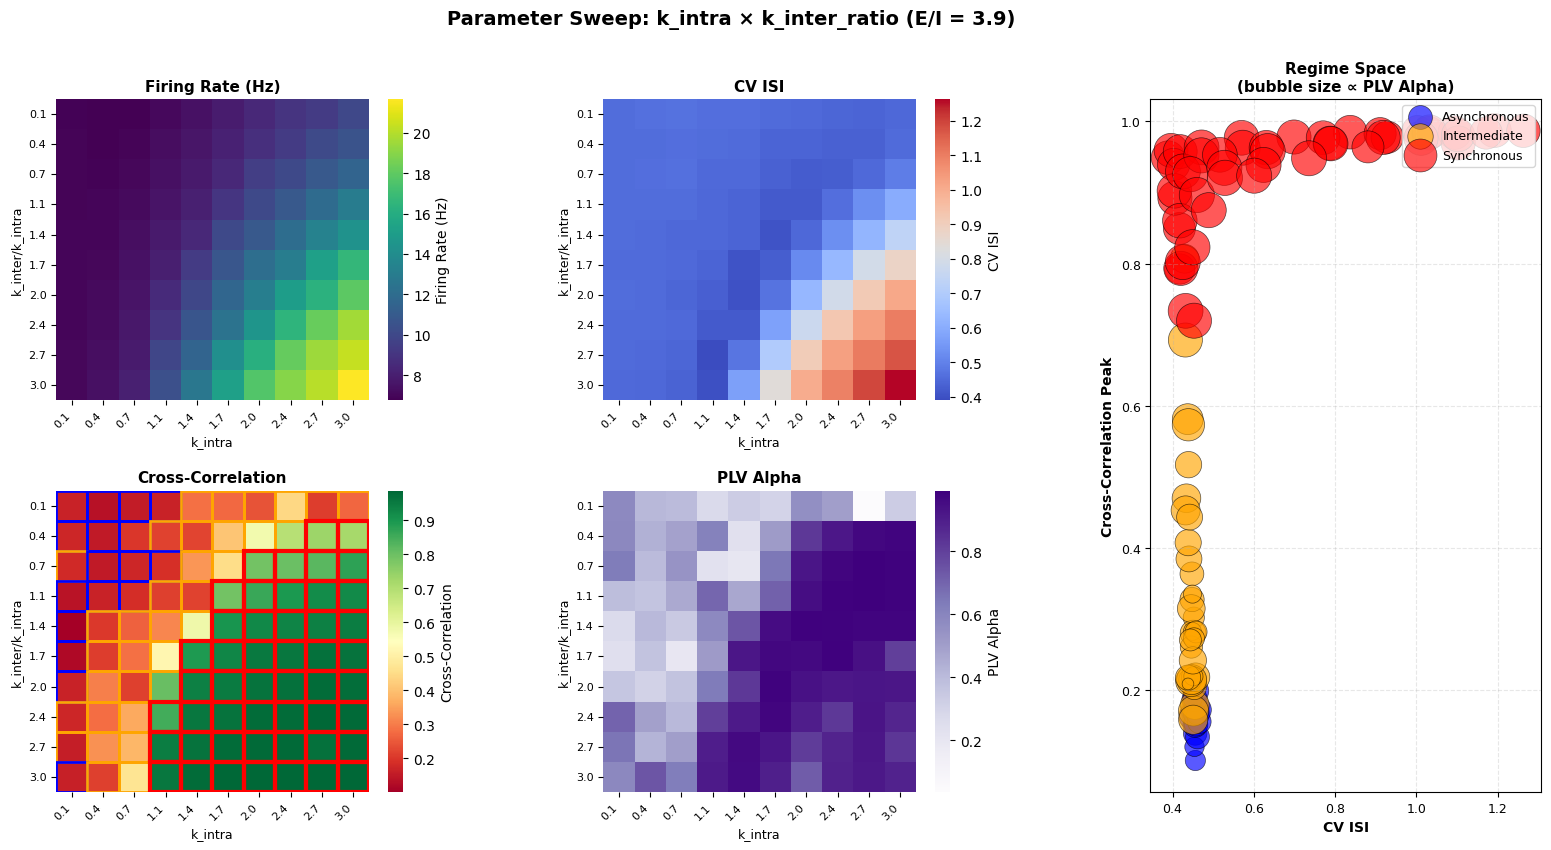

In [24]:
# =============================================================================
# VISUALIZACIÓN: HEATMAPS MEJORADOS CON REGÍMENES
# =============================================================================

fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.4, right=0.95)  # Ajuste de margen

# Definir axes (solo métricas clave)
ax1 = fig.add_subplot(gs[0, 0])  # Rate
ax2 = fig.add_subplot(gs[0, 1])  # CV
ax3 = fig.add_subplot(gs[1, 0])  # CC
ax4 = fig.add_subplot(gs[1, 1])  # PLV
ax5 = fig.add_subplot(gs[:, 2])  # Scatter regime space

# Configuración heatmaps (métricas clave únicamente)
heatmap_specs = [
    (matrices['mean_rate_A_mean'], ax1, 'Firing Rate (Hz)', 'viridis', '.1f'),
    (matrices['cv_A_mean'], ax2, 'CV ISI', 'coolwarm', '.1f'),
    (matrices['cc_peak_mean'], ax3, 'Cross-Correlation', 'RdYlGn', '.1f'),
    (matrices['plv_alpha_mean'], ax4, 'PLV Alpha', 'Purples', '.1f')
]

for mat, ax, title, cmap, fmt in heatmap_specs:
    sns.heatmap(mat, annot=False, fmt=fmt, cmap=cmap, ax=ax, 
                cbar_kws={'label': title})
    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.set_xlabel('k_intra', fontsize=9)
    ax.set_ylabel('k_inter/k_intra', fontsize=9)
    
    # Truncar floats en los ejes
    ax.set_xticklabels([f'{float(x.get_text()):.1f}' for x in ax.get_xticklabels()], 
                       rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels([f'{float(y.get_text()):.1f}' for y in ax.get_yticklabels()], 
                       rotation=0, fontsize=8)

# Marcar regímenes en CC heatmap
regime_mat = aggregated.pivot(index='k_inter_ratio', columns='k_intra', values='regime')
regime_colors = {'asynchronous': 'blue', 'intermediate': 'orange', 'synchronous': 'red'}
regime_lws = {'asynchronous': 2, 'intermediate': 2, 'synchronous': 3}

for i in range(len(regime_mat)):
    for j in range(len(regime_mat.columns)):
        regime = regime_mat.iloc[i, j]
        if pd.notna(regime) and regime in regime_colors:
            ax3.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, 
                                       edgecolor=regime_colors[regime], 
                                       lw=regime_lws[regime]))

# Leyenda regímenes - POSICIÓN CORREGIDA
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='none', edgecolor=c, label=r.capitalize(), linewidth=regime_lws[r])
    for r, c in regime_colors.items()
]
#ax3.legend(handles=legend_elements, loc='lower left', fontsize=8, framealpha=0.9)

# Scatter: CV vs CC (PLV = tamaño, regímenes = color)
for regime, color in regime_colors.items():
    subset = aggregated[aggregated['regime'] == regime]
    ax5.scatter(subset['cv_A_mean'], subset['cc_peak_mean'], 
               s=subset['plv_alpha_mean']*600 + 50, c=color, alpha=0.65, 
               edgecolors='black', linewidth=0.5, label=regime.capitalize())

ax5.set_xlabel('CV ISI', fontweight='bold', fontsize=10)
ax5.set_ylabel('Cross-Correlation Peak', fontweight='bold', fontsize=10)
ax5.set_title('Regime Space\n(bubble size ∝ PLV Alpha)', fontweight='bold', fontsize=11)
ax5.legend(loc='upper right', fontsize=9)
ax5.grid(alpha=0.3, linestyle='--')
ax5.tick_params(labelsize=9)

fig.suptitle('Parameter Sweep: k_intra × k_inter_ratio (E/I = 3.9)', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [12]:
# =============================================================================
# IDENTIFICAR CANDIDATOS POR RÉGIMEN
# =============================================================================

# Filtro base: rate y k_inter válidos
valid = aggregated[
    (aggregated['mean_rate_A_mean'] >= 4) & (aggregated['mean_rate_A_mean'] <= 16) &
    (aggregated['k_inter_ratio'] > 0)
]

# Separar por régimen
async_candidates = valid[valid['regime'] == 'asynchronous'].sort_values('beta_power_A_mean', ascending=False)
inter_candidates = valid[valid['regime'] == 'intermediate'].sort_values('beta_power_A_mean', ascending=False)
synch_candidates = valid[valid['regime'] == 'synchronous'].sort_values('beta_power_A_mean', ascending=False)

print("\n" + "="*70)
print("CANDIDATOS POR RÉGIMEN (filtrados por estabilidad)")
print("="*70)

cols_display = ['k_intra', 'k_inter_ratio', 'mean_rate_A_mean', 'cv_A_mean', 
                'cc_peak_mean', 'plv_alpha_mean', 'ei_ratio_A_mean']

print("\n🔵 ASÍNCRONO (bajo CV_std):")
print("-" * 70)
if len(async_cand) > 0:
    print(async_cand[cols_display].head(3).to_string(index=False))
else:
    print("  No hay candidatos estables")

print("\n🟠 INTERMEDIO (bajo CC_std):")
print("-" * 70)
if len(inter_cand) > 0:
    print(inter_cand[cols_display].head(3).to_string(index=False))
else:
    print("  No hay candidatos estables")

print("\n🔴 SÍNCRONO (mayor PLV):")
print("-" * 70)
if len(synch_cand) > 0:
    print(synch_cand[cols_display].head(3).to_string(index=False))
else:
    print("  No hay candidatos estables")

# =============================================================================
# RECOMENDACIONES
# =============================================================================

print("\n" + "="*70)
print("MEJORES PUNTOS PARA DELAY SWEEP")
print("="*70)

for regime, cands, emoji in [('asynchronous', async_cand, '🔵'),
                             ('intermediate', inter_cand, '🟠'),
                             ('synchronous', synch_cand, '🔴')]:
    if len(cands) > 0:
        best = cands.iloc[0]
        print(f"\n{emoji} {regime.upper()}:")
        print(f"  k_intra={best['k_intra']:.2f}, k_inter={best['k_intra']*best['k_inter_ratio']:.2f}")
        print(f"  Rate={best['mean_rate_A_mean']:.1f}Hz, CV={best['cv_A_mean']:.2f}, E/I={best['ei_ratio_A_mean']:.2f}")
        print(f"  CC={best['cc_peak_mean']:.3f}, PLV={best['plv_alpha_mean']:.3f}")

# Baseline
baseline = aggregated[aggregated['k_inter_ratio'] == 0.0]
if len(baseline) > 0:
    print("\n" + "="*70)
    print("BASELINE (sin acoplamiento):")
    print(baseline[['k_intra', 'mean_rate_A_mean', 'cv_A_mean']].to_string(index=False))



CANDIDATOS POR RÉGIMEN (filtrados por estabilidad)

🔵 ASÍNCRONO (bajo CV_std):
----------------------------------------------------------------------
 k_intra  k_inter_ratio  mean_rate_A_mean  cv_A_mean  cc_peak_mean  plv_alpha_mean  ei_ratio_A_mean
     0.1       0.100000            6.8610   0.456834      0.166094        0.582792         0.602211
     0.1       0.422222            6.8750   0.455682      0.172609        0.584878         0.602741
     0.1       1.388889            6.9347   0.456210      0.100825        0.270209         0.604126

🟠 INTERMEDIO (bajo CC_std):
----------------------------------------------------------------------
 k_intra  k_inter_ratio  mean_rate_A_mean  cv_A_mean  cc_peak_mean  plv_alpha_mean  ei_ratio_A_mean
     0.1       0.744444            6.8822   0.454872      0.179018        0.630720         0.601497
     0.1       2.355556            6.9619   0.451620      0.170642        0.703611         0.602056
     0.1       2.677778            6.9850   0.450

In [13]:
import pickle
from pathlib import Path
from datetime import datetime
import json
import numpy as np

# =============================================================================
# HELPER: Convertir config a JSON-serializable
# =============================================================================

def make_json_serializable(obj):
    """Convierte objetos complejos a tipos serializables en JSON"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.number, np.bool_)):
        return obj.item()
    elif isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(v) for v in obj]
    elif hasattr(obj, '__dict__') and not isinstance(obj, type):
        # Objetos complejos como Brian2: convertir a string
        return str(obj)
    else:
        return obj

# =============================================================================
# GUARDAR RESULTADOS
# =============================================================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = Path("./results/experiments/k_sweep_2d")
output_dir.mkdir(parents=True, exist_ok=True)

# Configuración limpia (solo valores primitivos)
config = {
    'experiment': 'k_sweep_2d',
    'timestamp': timestamp,
    'population_params': {
        'Ne': POPULATION_PARAMS['Ne'],
        'Ni': POPULATION_PARAMS['Ni'],
        # Añadir solo parámetros primitivos, no objetos de Brian2
    },
    'k_intra_values': K_INTRA_VALUES.tolist() if isinstance(K_INTRA_VALUES, np.ndarray) else K_INTRA_VALUES,
    'k_inter_ratios': K_INTER_RATIOS.tolist() if isinstance(K_INTER_RATIOS, np.ndarray) else K_INTER_RATIOS,
    'sim_config': make_json_serializable(SIM_CONFIG),
    'EI_balance_factor': 3.9,
    'regime_classification': {
        'method': 'multivariate',
        'criteria': {
            'asynchronous': 'CC < 0.25 AND CV > 0.8 AND PLV < 0.3',
            'synchronous': 'CC > 0.6 AND CV < 0.5 AND PLV > 0.5',
            'intermediate': 'else'
        }
    },
    'stability_filters': {
        'rate': [3, 15],
        'ei_ratio': [0.5, 2.0],
        'burst_ratio': '<2.0'
    }
}

# Guardar config como JSON
config_path = output_dir / f"config_{timestamp}.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

# Resultados completos (con objetos complejos)
results_dict = {
    'config': config,
    'all_trials': all_results,
    'aggregated': aggregated.to_dict('records'),
    'stable_candidates': {
        'asynchronous': async_cand.to_dict('records'),
        'intermediate': inter_cand.to_dict('records'),
        'synchronous': synch_cand.to_dict('records')
    },
    'baseline': baseline.to_dict('records') if len(baseline) > 0 else [],
    'recommended_points': {}
}

# Guardar recommended points
for regime, candidates in [('asynchronous', async_candidates), 
                           ('intermediate', inter_candidates), 
                           ('synchronous', synch_candidates)]:
    if len(candidates) > 0:
        best = candidates.iloc[0]
        results_dict['recommended_points'][regime] = {
            'k_intra': float(best['k_intra']),
            'k_inter_ratio': float(best['k_inter_ratio']),
            'metrics': {
                'mean_rate': float(best['mean_rate_A_mean']),
                'cv': float(best['cv_A_mean']),
                'cc_peak': float(best['cc_peak_mean']),
                'plv_alpha': float(best['plv_alpha_mean']),
                'coherence': float(best['coherence_peak_mean']),
                'ei_ratio': float(best['ei_ratio_A_mean']),
                'burst_ratio': float(best['burst_ratio_A_mean'])
            }
        }

# Guardar resultados completos como pickle (sin problemas de serialización)
results_pkl_path = output_dir / f"results_{timestamp}.pkl"
with open(results_pkl_path, 'wb') as f:
    pickle.dump(results_dict, f)

# Guardar resumen legible como JSON
summary = {
    'timestamp': timestamp,
    'n_trials': len(all_results),
    'recommended_points': results_dict['recommended_points'],
    'regimes_found': {
        'asynchronous': len(async_cand),
        'intermediate': len(inter_cand),
        'synchronous': len(synch_cand)
    }
}
summary_path = output_dir / f"summary_{timestamp}.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

# Guardar DataFrames como CSV (opcional, útil para análisis externo)
aggregated.to_csv(output_dir / f"aggregated_{timestamp}.csv", index=False)

# Figuras
fig_path = output_dir / f"heatmaps_{timestamp}.png"
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

logger.info(f"\n{'='*70}")
logger.info(f"RESULTADOS GUARDADOS:")
logger.info(f"  Config (JSON): {config_path}")
logger.info(f"  Results (PKL): {results_pkl_path}")
logger.info(f"  Summary (JSON): {summary_path}")
logger.info(f"  Aggregated (CSV): {output_dir}/aggregated_{timestamp}.csv")
logger.info(f"  Heatmaps: {fig_path}")
logger.info(f"{'='*70}")

INFO     | __main__:<module>:129 - 
INFO     | __main__:<module>:130 - RESULTADOS GUARDADOS:
INFO     | __main__:<module>:131 -   Config (JSON): results/experiments/k_sweep_2d/config_20251114_171925.json
INFO     | __main__:<module>:132 -   Results (PKL): results/experiments/k_sweep_2d/results_20251114_171925.pkl
INFO     | __main__:<module>:133 -   Summary (JSON): results/experiments/k_sweep_2d/summary_20251114_171925.json
INFO     | __main__:<module>:134 -   Aggregated (CSV): results/experiments/k_sweep_2d/aggregated_20251114_171925.csv
INFO     | __main__:<module>:135 -   Heatmaps: results/experiments/k_sweep_2d/heatmaps_20251114_171925.png
INFO     | __main__:<module>:136 - ======================================================================


In [14]:
import pickle
from pathlib import Path
from datetime import datetime
import json
import numpy as np

# =============================================================================
# HELPER: Convertir a JSON-serializable
# =============================================================================

def extract_serializable_config(pop_params, sim_config):
    """Extrae solo valores serializables de los configs"""
    clean_pop = {}
    for k, v in pop_params.items():
        if isinstance(v, (int, float, str, bool)):
            clean_pop[k] = v
        elif isinstance(v, np.ndarray):
            clean_pop[k] = v.tolist()
        elif isinstance(v, (np.number, np.bool_)):
            clean_pop[k] = v.item()
        # Ignorar objetos de Brian2 (Equations, etc.)
    
    clean_sim = {}
    for k, v in sim_config.items():
        if isinstance(v, (int, float, str, bool)):
            clean_sim[k] = v
        elif isinstance(v, np.ndarray):
            clean_sim[k] = v.tolist()
        elif hasattr(v, 'dim'):  # Brian2 Quantity
            clean_sim[k] = float(v)
    
    return clean_pop, clean_sim

# =============================================================================
# GUARDAR RESULTADOS
# =============================================================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = Path("./results/experiments/k_sweep_2d")
output_dir.mkdir(parents=True, exist_ok=True)

# Extraer valores serializables
clean_pop, clean_sim = extract_serializable_config(POPULATION_PARAMS, SIM_CONFIG)

config = {
    'experiment': 'k_sweep_2d',
    'timestamp': timestamp,
    'population_params': clean_pop,
    'k_intra_values': K_INTRA_VALUES.tolist(),
    'k_inter_ratios': K_INTER_RATIOS.tolist(),
    'sim_config': clean_sim,
    'EI_balance_factor': 3.9,
    'regime_classification': {
        'method': 'multivariate',
        'criteria': {
            'asynchronous': 'CC < 0.25 AND CV > 0.8 AND PLV < 0.3',
            'synchronous': 'CC > 0.6 AND CV < 0.5 AND PLV > 0.5',
            'intermediate': 'else'
        }
    },
    'stability_filters': {
        'rate': [3, 15],
        'ei_ratio': [0.5, 2.0],
        'burst_ratio': '<2.0'
    }
}

# JSON: Config limpio
config_path = output_dir / f"config_{timestamp}.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

# Resultados completos
results_dict = {
    'config': config,
    'all_trials': all_results,
    'aggregated': aggregated.to_dict('records'),
    'stable_candidates': {
        'asynchronous': async_cand.to_dict('records'),
        'intermediate': inter_cand.to_dict('records'),
        'synchronous': synch_cand.to_dict('records')
    },
    'baseline': baseline.to_dict('records') if len(baseline) > 0 else [],
    'recommended_points': {}
}

# Recommended points
for regime, candidates in [('asynchronous', async_candidates), 
                           ('intermediate', inter_candidates), 
                           ('synchronous', synch_candidates)]:
    if len(candidates) > 0:
        best = candidates.iloc[0]
        results_dict['recommended_points'][regime] = {
            'k_intra': float(best['k_intra']),
            'k_inter_ratio': float(best['k_inter_ratio']),
            'metrics': {
                'mean_rate': float(best['mean_rate_A_mean']),
                'cv': float(best['cv_A_mean']),
                'cc_peak': float(best['cc_peak_mean']),
                'plv_alpha': float(best['plv_alpha_mean']),
                'coherence': float(best['coherence_peak_mean']),
                'ei_ratio': float(best['ei_ratio_A_mean']),
                'burst_ratio': float(best['burst_ratio_A_mean'])
            }
        }

# Pickle: Resultados completos
results_pkl_path = output_dir / f"results_{timestamp}.pkl"
with open(results_pkl_path, 'wb') as f:
    pickle.dump(results_dict, f)

# JSON: Resumen ejecutivo
summary = {
    'timestamp': timestamp,
    'n_trials': len(all_results),
    'n_stable_trials': len(aggregated),
    'recommended_points': results_dict['recommended_points'],
    'regimes_found': {
        'asynchronous': len(async_cand),
        'intermediate': len(inter_cand),
        'synchronous': len(synch_cand)
    }
}
summary_path = output_dir / f"summary_{timestamp}.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

# CSV: DataFrame para análisis
aggregated.to_csv(output_dir / f"aggregated_{timestamp}.csv", index=False)

# Figuras
fig_path = output_dir / f"heatmaps_{timestamp}.png"
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

logger.info(f"\n{'='*70}")
logger.info(f"RESULTADOS GUARDADOS:")
logger.info(f"  Config (JSON): {config_path}")
logger.info(f"  Results (PKL): {results_pkl_path}")
logger.info(f"  Summary (JSON): {summary_path}")
logger.info(f"  Aggregated (CSV): {output_dir}/aggregated_{timestamp}.csv")
logger.info(f"  Heatmaps: {fig_path}")
logger.info(f"{'='*70}")

INFO     | __main__:<module>:135 - 
INFO     | __main__:<module>:136 - RESULTADOS GUARDADOS:
INFO     | __main__:<module>:137 -   Config (JSON): results/experiments/k_sweep_2d/config_20251114_171926.json
INFO     | __main__:<module>:138 -   Results (PKL): results/experiments/k_sweep_2d/results_20251114_171926.pkl
INFO     | __main__:<module>:139 -   Summary (JSON): results/experiments/k_sweep_2d/summary_20251114_171926.json
INFO     | __main__:<module>:140 -   Aggregated (CSV): results/experiments/k_sweep_2d/aggregated_20251114_171926.csv
INFO     | __main__:<module>:141 -   Heatmaps: results/experiments/k_sweep_2d/heatmaps_20251114_171926.png
INFO     | __main__:<module>:142 - ======================================================================
